In [ ]:
pip install opendatasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import opendatasets as od

od.download(
    "https://www.kaggle.com/datasets/spscientist/students-performance-in-exams")

Skipping, found downloaded files in "./students-performance-in-exams" (use force=True to force download)


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import scipy.stats as stats
from statsmodels.formula.api import ols
from statsmodels.graphics.factorplots import interaction_plot
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from scipy.stats import bartlett
from mlxtend.evaluate import permutation_test
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

In [ ]:
sns.set_style('darkgrid')
SEED = 42
np.random.seed(SEED)

In [ ]:
file =('/content/students-performance-in-exams/StudentsPerformance.csv')
df = pd.read_csv(file)

In [ ]:
df

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,female,group B,bachelor's degree,standard,none,72,72,74
1,female,group C,some college,standard,completed,69,90,88
2,female,group B,master's degree,standard,none,90,95,93
3,male,group A,associate's degree,free/reduced,none,47,57,44
4,male,group C,some college,standard,none,76,78,75
...,...,...,...,...,...,...,...,...
995,female,group E,master's degree,standard,completed,88,99,95
996,male,group C,high school,free/reduced,none,62,55,55
997,female,group C,high school,free/reduced,completed,59,71,65
998,female,group D,some college,standard,completed,68,78,77


In [ ]:
column_mapping = {
    'race/ethnicity': 'group',
    'parental level of education': 'parent_education',
    'test preparation course': 'preparation',
    'math score': 'math_score',
    'reading score': 'reading_score',
    'writing score': 'writing_score'

}


df = df.rename(columns=column_mapping)

In [ ]:
df["average_score"] = df[["math_score", "reading_score", "writing_score"]].mean(axis=1).astype(int)
df

,gender,group,parent_education,lunch,preparation,math_score,reading_score,writing_score,average_score
0,female,group B,bachelor's degree,standard,none,72,72,74,72
1,female,group C,some college,standard,completed,69,90,88,82
2,female,group B,master's degree,standard,none,90,95,93,92
3,male,group A,associate's degree,free/reduced,none,47,57,44,49
4,male,group C,some college,standard,none,76,78,75,76
...,...,...,...,...,...,...,...,...,...
995,female,group E,master's degree,standard,completed,88,99,95,94
996,male,group C,high school,free/reduced,none,62,55,55,57
997,female,group C,high school,free/reduced,completed,59,71,65,65
998,female,group D,some college,standard,completed,68,78,77,74


female    518
male      482
Name: gender, dtype: int64


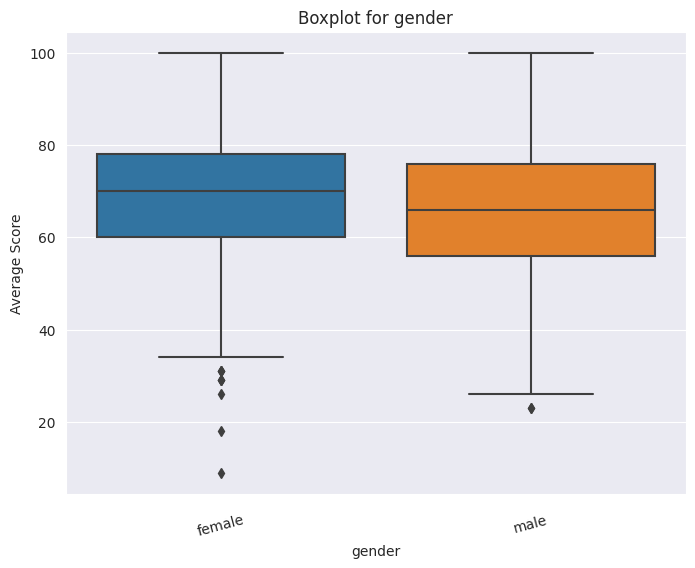

group C    319
group D    262
group B    190
group E    140
group A     89
Name: group, dtype: int64


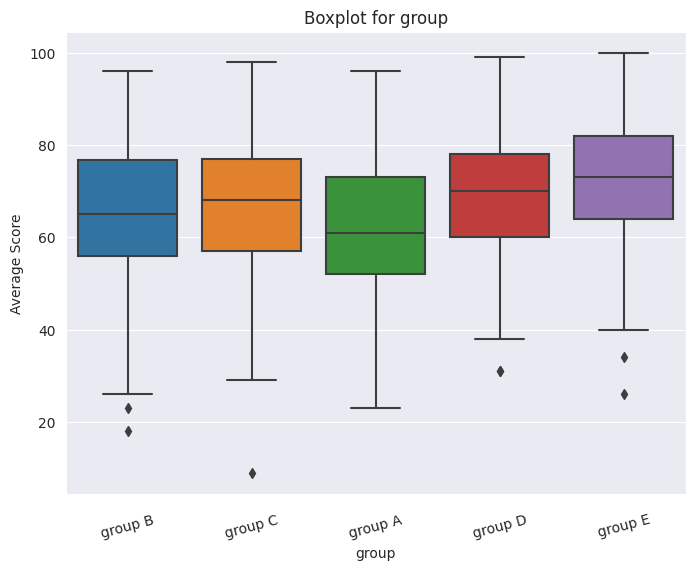

some college          226
associate's degree    222
high school           196
some high school      179
bachelor's degree     118
master's degree        59
Name: parent_education, dtype: int64


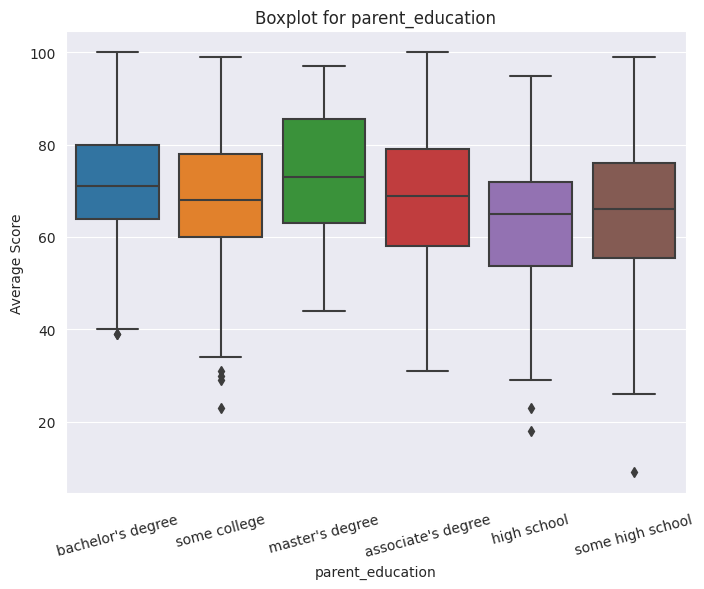

standard        645
free/reduced    355
Name: lunch, dtype: int64


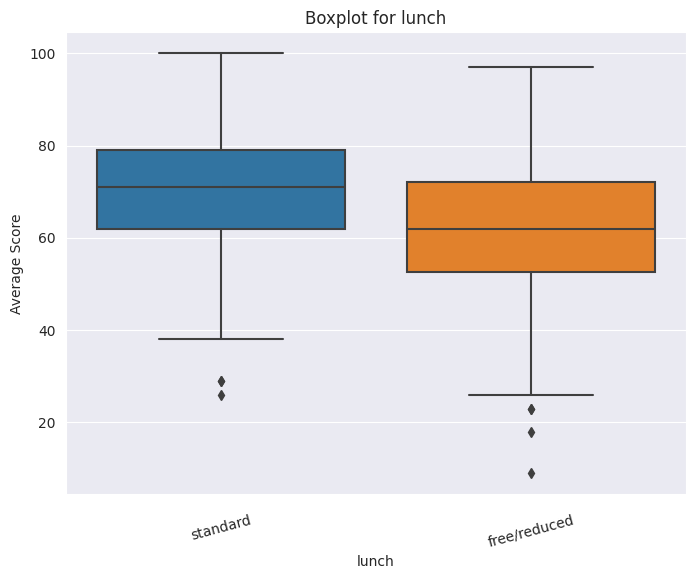

none         642
completed    358
Name: preparation, dtype: int64


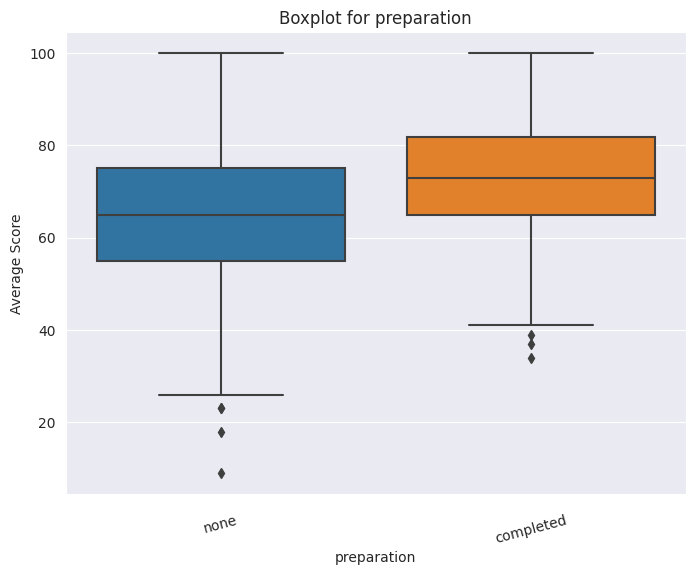

In [ ]:
for column in df.columns[:5]:
    print(df[column].value_counts())
    plt.figure(figsize=(8, 6))
    sns.boxplot(data=df, x=column, y='average_score')
    plt.title(f'Boxplot for {column}')
    plt.xlabel(column)
    plt.ylabel('Average Score')
    plt.xticks(rotation=15)
    plt.tick_params(axis='x', which='major', pad=10)
    plt.show()

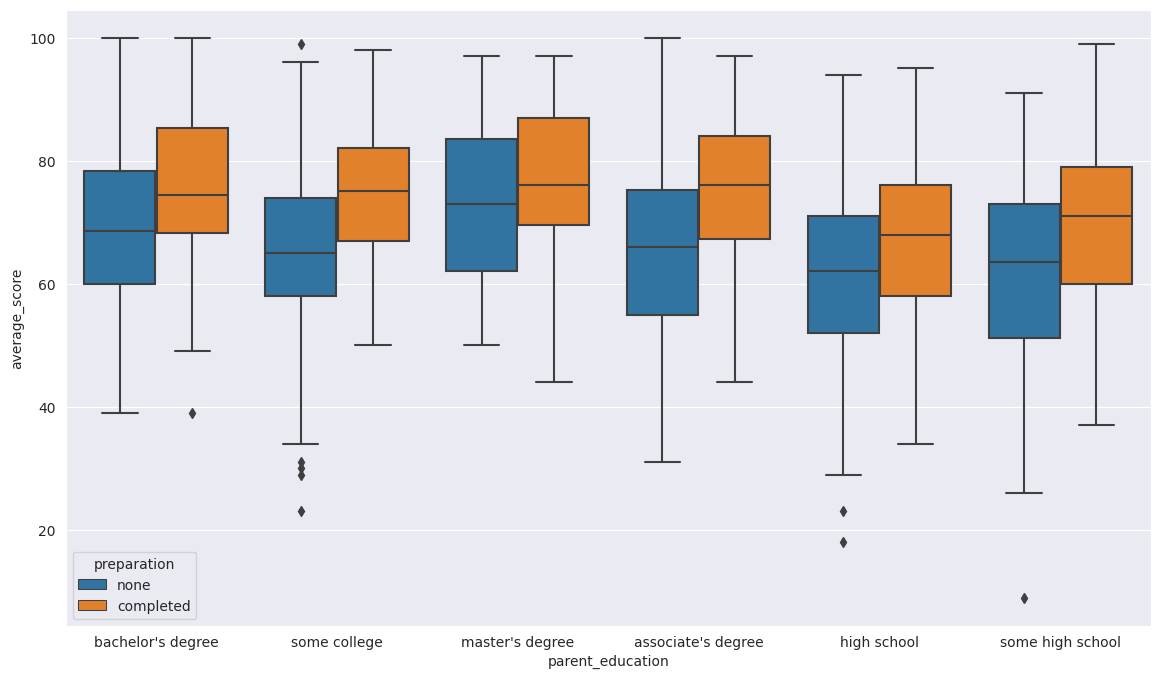

In [ ]:
df = df[['parent_education', 'preparation', 'average_score']]

plt.figure(figsize=(14, 8))
sns.boxplot(data=df, x='parent_education', y='average_score', hue = 'preparation')
plt.show()

In [ ]:
for education in np.unique(df['parent_education'].values):
    with_prep   = df[(df['parent_education'] == education) & (df['preparation'] == 'completed')]
    without_prep   = df[(df['parent_education'] == education) & (df['preparation'] == 'none')]
    print(f"With {education} level and preparation completed: {len(with_prep)}")
    print(f"With {education} level and preparation none: {len(without_prep)}")

With associate's degree level and preparation completed: 82
With associate's degree level and preparation none: 140
With bachelor's degree level and preparation completed: 46
With bachelor's degree level and preparation none: 72
With high school level and preparation completed: 56
With high school level and preparation none: 140
With master's degree level and preparation completed: 20
With master's degree level and preparation none: 39
With some college level and preparation completed: 77
With some college level and preparation none: 149
With some high school level and preparation completed: 77
With some high school level and preparation none: 102


In [ ]:
formula = 'average_score ~ C(parent_education) + C(preparation) + C(parent_education):C(preparation)'

model = ols(formula, data = df).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
display(anova_table)

,sum_sq,df,F,PR(>F)
C(parent_education),9897.237439,5.0,10.902645,3.144059e-10
C(preparation),12868.238595,1.0,70.877269,1.324033e-16
C(parent_education):C(preparation),567.545276,5.0,0.625199,6.805990e-01
Residual,179377.957595,988.0,NaN,NaN


In [ ]:
print("Main Effect of Parent education:")
if anova_table['PR(>F)']['C(parent_education)'] < 0.05:
    print("The factor 'parent education' has a significant effect on average score.")
else:
    print("The factor 'parent education' does not have a significant effect on average score.")

print("\nMain Effect of Preparation:")
if anova_table['PR(>F)']['C(preparation)'] < 0.05:
    print("The factor 'preparation' has a significant effect on average score.")
else:
    print("The factor 'preparation' does not have a significant effect on average score.")

print("\nInteraction Effect:")
if anova_table['PR(>F)']['C(parent_education):C(preparation)'] < 0.05:
    print("There is a significant interaction effect between 'parent education' and 'preparation'.")
else:
    print("There is no significant interaction effect between 'parent education' and 'preparation'.")

Main Effect of Parent education:
The factor 'parent education' has a significant effect on average score.

Main Effect of Preparation:
The factor 'preparation' has a significant effect on average score.

Interaction Effect:
There is no significant interaction effect between 'parent education' and 'preparation'.


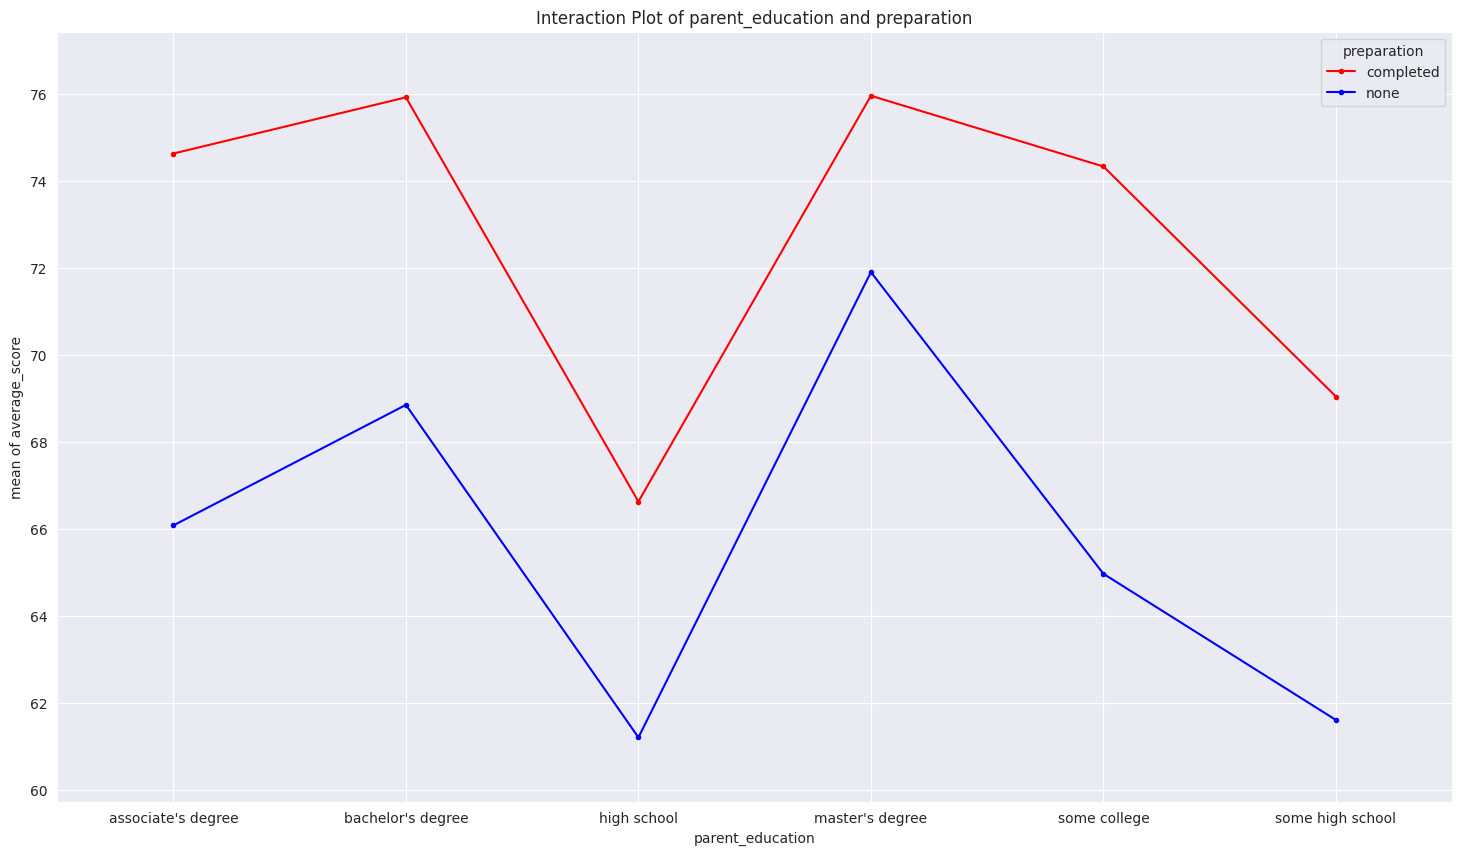

In [ ]:
fig, ax = plt.subplots(figsize = (18, 10))
fig = interaction_plot(df['parent_education'], df['preparation'], df['average_score'], colors=['red', 'blue'], ax = ax)
plt.title('Interaction Plot of parent_education and preparation')
plt.show()

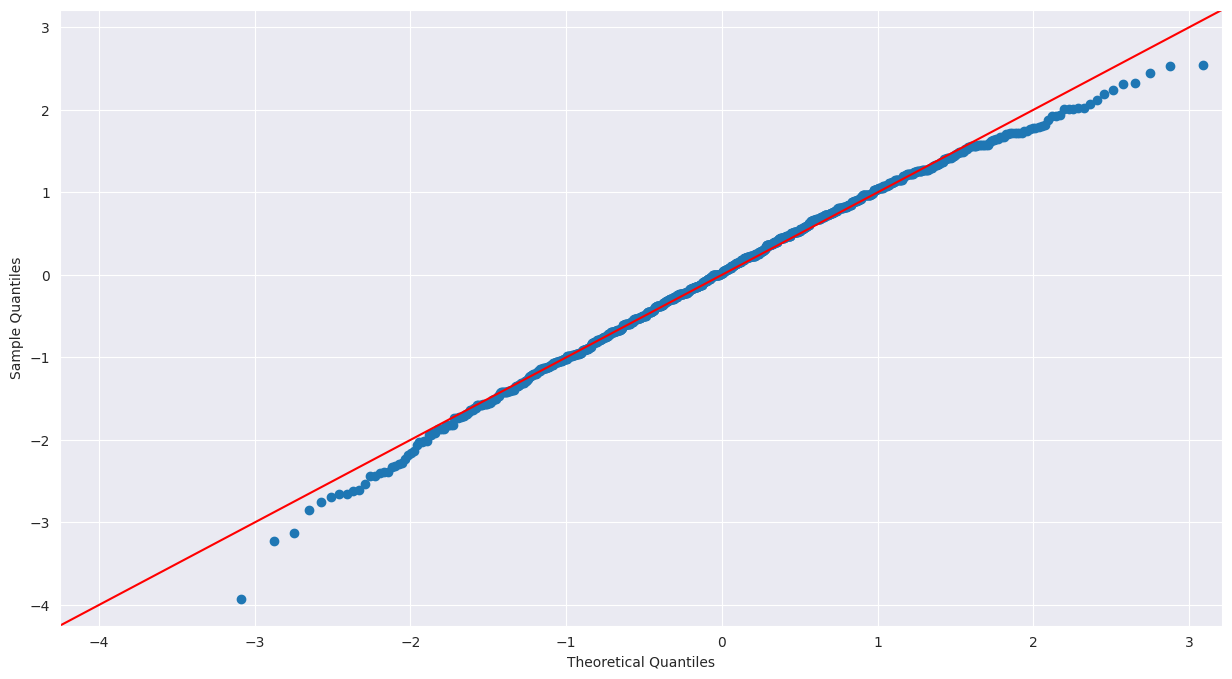

In [ ]:
fig, ax = plt.subplots(figsize = (15, 8))
sm.qqplot(model.resid, fit=True, line="45", ax = ax)
plt.show()

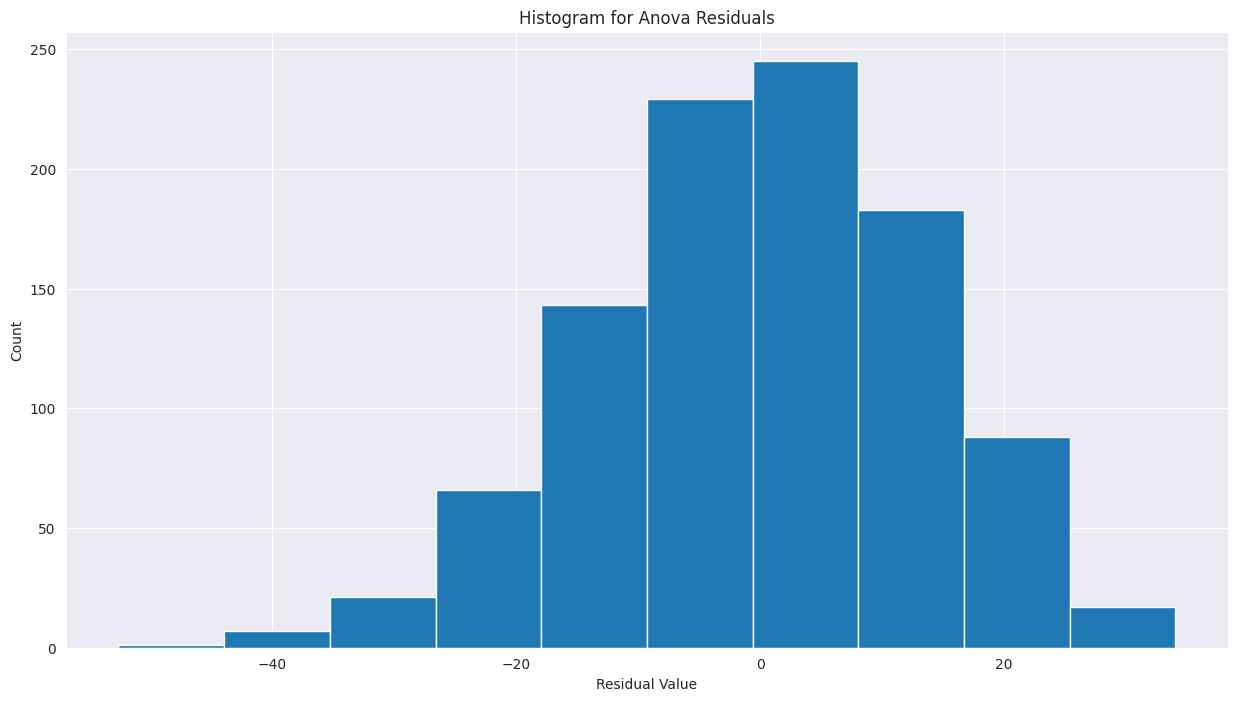

In [ ]:
plt.figure(figsize = (15, 8))
plt.hist(model.resid)
plt.title('Histogram for Anova Residuals')
plt.xlabel('Residual Value')
plt.ylabel('Count')
plt.show()

In [ ]:
tukey_results = pairwise_tukeyhsd(df['average_score'], df['parent_education'])
print(tukey_results)

            Multiple Comparison of Means - Tukey HSD, FWER=0.05             
      group1             group2      meandiff p-adj   lower    upper  reject
----------------------------------------------------------------------------
associate's degree bachelor's degree   2.3675 0.6695   -2.163   6.898  False
associate's degree       high school  -6.4791    0.0 -10.3768 -2.5814   True
associate's degree   master's degree    4.037 0.3552  -1.7878  9.8617  False
associate's degree      some college  -1.0794 0.9639  -4.8372  2.6784  False
associate's degree  some high school  -4.4298 0.0198  -8.4246  -0.435   True
 bachelor's degree       high school  -8.8466    0.0 -13.4802  -4.213   True
 bachelor's degree   master's degree   1.6695 0.9752  -4.6713  8.0103  False
 bachelor's degree      some college  -3.4468 0.2485  -7.9634  1.0697  False
 bachelor's degree  some high school  -6.7972 0.0006 -11.5128 -2.0816   True
       high school   master's degree  10.5161    0.0   4.6108 16.4214   True

In [ ]:
tukey_results = pairwise_tukeyhsd(df['average_score'], df['preparation'])
print(tukey_results)

 Multiple Comparison of Means - Tukey HSD, FWER=0.05  
  group1  group2 meandiff p-adj  lower   upper  reject
------------------------------------------------------
completed   none  -7.6345   0.0 -9.4198 -5.8493   True
------------------------------------------------------


In [ ]:
groups = []
for education in df['parent_education'].unique():
    for prep in df['preparation'].unique():
        group = df['average_score'][(df['parent_education'] == education) & (df['preparation'] == prep)]
        groups.append(group)

statistic, p_value = bartlett(*groups)
print('Bartlett Test - Statistic:', statistic)
print('Bartlett Test - p-value:', p_value)

Bartlett Test - Statistic: 9.126801835546628
Bartlett Test - p-value: 0.6101891018595884


In [ ]:
for education in np.unique(df['parent_education'].values):
    with_prep   = df[(df['parent_education'] == education) & (df['preparation'] == 'completed')]
    without_prep   = df[(df['parent_education'] == education) & (df['preparation'] == 'none')]

    pvalue = permutation_test(with_prep['average_score'].values, without_prep['average_score'].values, method = 'approximate',
                        num_rounds = 1000, seed = SEED)
    print('Permutation Test for: {}  p-value: {}' \
          .format(education, np.round(pvalue, 5)))

Permutation Test for: associate's degree  p-value: 0.0
Permutation Test for: bachelor's degree  p-value: 0.01
Permutation Test for: high school  p-value: 0.016
Permutation Test for: master's degree  p-value: 0.258
Permutation Test for: some college  p-value: 0.0
Permutation Test for: some high school  p-value: 0.001


In [ ]:
w, pvalue = stats.shapiro(model.resid)
print("Shapiro-Wilk Test Results, W: {}, p-value: {}".format(np.round(w, 4), np.round(pvalue, 4)))

Shapiro-Wilk Test Results, W: 0.9944, p-value: 0.0009


Task 2

In [ ]:
od.download(
    "https://www.kaggle.com/datasets/aungpyaeap/fish-market?datasetId=229906&sortBy=voteCount")

Skipping, found downloaded files in "./fish-market" (use force=True to force download)


In [ ]:
file =('/content/fish-market/Fish.csv')
df = pd.read_csv(file)

In [ ]:
df

,Species,Weight,Length1,Length2,Length3,Height,Width
0,Bream,242.0,23.2,25.4,30.0,11.5200,4.0200
1,Bream,290.0,24.0,26.3,31.2,12.4800,4.3056
2,Bream,340.0,23.9,26.5,31.1,12.3778,4.6961
3,Bream,363.0,26.3,29.0,33.5,12.7300,4.4555
4,Bream,430.0,26.5,29.0,34.0,12.4440,5.1340
...,...,...,...,...,...,...,...
154,Smelt,12.2,11.5,12.2,13.4,2.0904,1.3936
155,Smelt,13.4,11.7,12.4,13.5,2.4300,1.2690
156,Smelt,12.2,12.1,13.0,13.8,2.2770,1.2558
157,Smelt,19.7,13.2,14.3,15.2,2.8728,2.0672


<Axes: xlabel='Weight', ylabel='Count'>

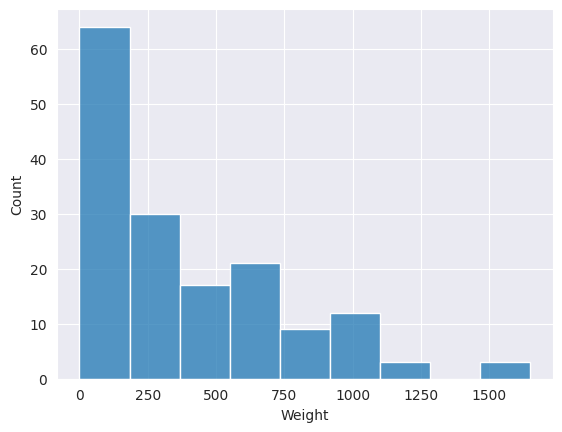

In [ ]:
sns.histplot(data=df, x='Weight')

In [ ]:
df = df.drop(["Species",  'Length2', 'Length3', 'Height'], axis = 1)

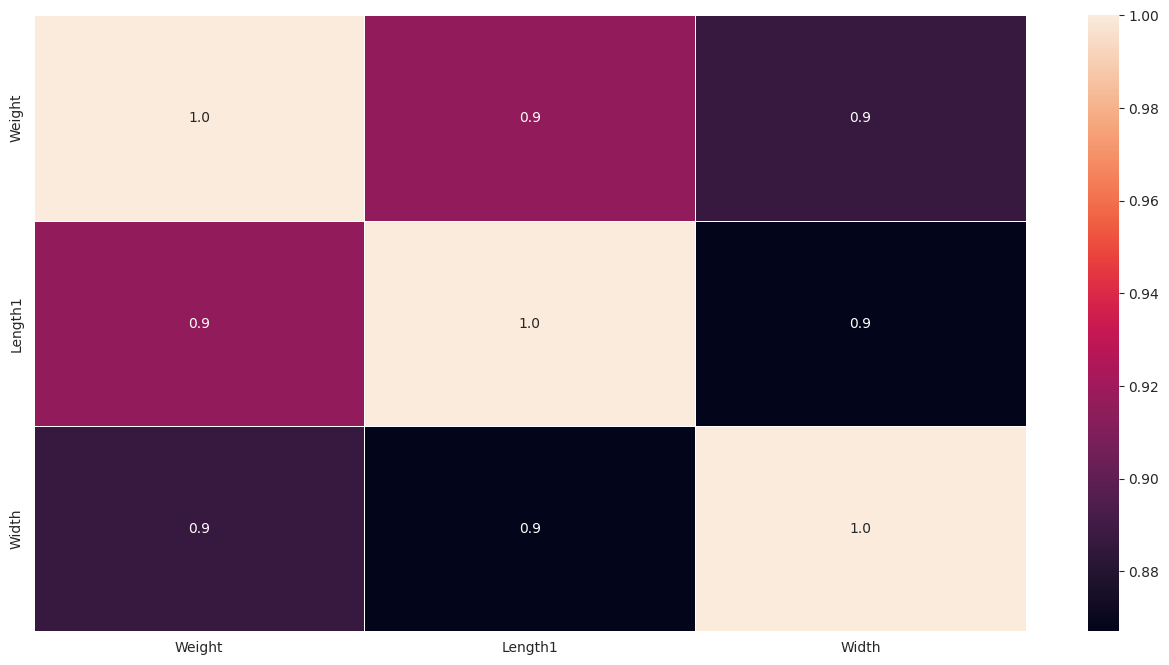

In [ ]:
f,ax = plt.subplots(figsize=(16, 8))
sns.heatmap(df.corr(), annot=True, linewidths=.5, fmt= '.1f',ax=ax)
plt.show()

In [ ]:
y = df[["Weight"]]
X = df.drop(['Weight'], axis = 1)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)
print('X_train: ', np.shape(X_train))
print('y_train: ', np.shape(y_train))
print('X_test: ', np.shape(X_test))
print('y_test: ', np.shape(y_test))

X_train:  (127, 2)
y_train:  (127, 1)
X_test:  (32, 2)
y_test:  (32, 1)


In [ ]:
model = LinearRegression()
model.fit(X_train, y_train)
predictions = model.predict(X_test)
print(r2_score(y_test, predictions))

0.8554123261968226


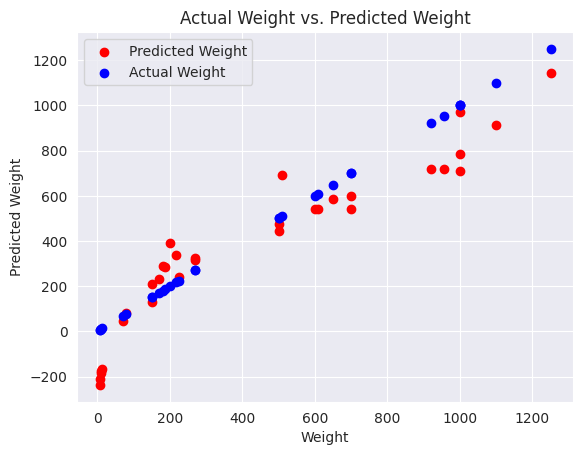

In [ ]:
plt.scatter(y_test, predictions, c='red', label='Predicted Weight')
plt.scatter(y_test, y_test, c='blue', label='Actual Weight')
plt.xlabel("Weight")
plt.ylabel("Predicted Weight")
plt.title("Actual Weight vs. Predicted Weight")
plt.legend()
plt.show()

In [ ]:
X_train_Summary= sm.add_constant(X_train)
ls=sm.OLS(y_train,X_train_Summary).fit()
print(ls.summary())

                            OLS Regression Results                            
Dep. Variable:                 Weight   R-squared:                       0.876
Model:                            OLS   Adj. R-squared:                  0.874
Method:                 Least Squares   F-statistic:                     437.1
Date:                Tue, 27 Jun 2023   Prob (F-statistic):           6.90e-57
Time:                        06:32:20   Log-Likelihood:                -791.94
No. Observations:                 127   AIC:                             1590.
Df Residuals:                     124   BIC:                             1598.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -519.7835     32.871    -15.813      0.0

In [ ]:
formula = "Weight ~ Length1 + Width + Length1 * Width"
model = ols(formula, data=df).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
display(anova_table)

,sum_sq,df,F,PR(>F)
Length1,1.764219e+06,1.0,243.828819,1.261634e-33
Width,6.985141e+05,1.0,96.540116,5.168126e-18
Length1:Width,1.449385e+06,1.0,200.316399,1.014922e-29
Residual,1.121499e+06,155.0,NaN,NaN


In [ ]:
w, pvalue = stats.shapiro(model.resid)
print("Shapiro-Wilk Test Results, W: {}, p-value: {}".format(np.round(w, 4), np.round(pvalue, 4)))

Shapiro-Wilk Test Results, W: 0.9519, p-value: 0.0
